# TMS/Neuronavigation Project
## .bag file reading

In this notebook, we will read RGBD data from an example bag file, `raj_face.bag`, in Python for (supposed) later manipulation.
This notebook is heavily based off of [this example notebook](https://nbviewer.jupyter.org/github/IntelRealSense/librealsense/blob/jupyter/notebooks/distance_to_object.ipynb) from the librealsense library examples/documentation.

## Prerequisites
-----

### Install python dependencies to Colab

In [1]:
!pip install pyrealsense2

     |████████████████████████████████| 9.7MB 2.7MB/s 


### Download .bag video file & dlib .dat model

In [2]:
!wget -nc -O raj_face.bag https://duke.box.com/shared/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
!wget -nc -O shape_predictor_68_face_landmarks.dat https://duke.box.com/shared/static/a8w66egidf8wiq2e9rfjqv8gxiuw6gp6.dat

--2020-10-17 07:45:56--  https://duke.box.com/shared/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
Resolving duke.box.com (duke.box.com)... 103.116.4.197
Connecting to duke.box.com (duke.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag [following]
--2020-10-17 07:45:56--  https://duke.box.com/public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
Reusing existing connection to duke.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://duke.app.box.com/public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag [following]
--2020-10-17 07:45:56--  https://duke.app.box.com/public/static/whc4xwxrmeci1l7bbs4lxc6zknfg5y5q.bag
Resolving duke.app.box.com (duke.app.box.com)... 103.116.4.201
Connecting to duke.app.box.com (duke.app.box.com)|103.116.4.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

### Python Imports

In [3]:
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import cv2                                # state of the art computer vision algorithms library
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import dlib                               # Face & facial landmark detection
print("Python requirements imported successfully.")

Python requirements imported successfully.


## Data Decoding & Visualization
-----

### Reading data from .bag file

In [4]:
BAG_FILENAME = "raj_face.bag"

# Setup:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(BAG_FILENAME)
profile = pipe.start(cfg)

# --------------- #
# SKIP 150 frames (150 is arbitrary; just to skip to somewhere in middle of video)
for x in range(150):
    pipe.wait_for_frames()
# --------------- #
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print(f"{BAG_FILENAME} frame data read successfully")

raj_face.bag frame data read successfully


### RGB decoding/visualization

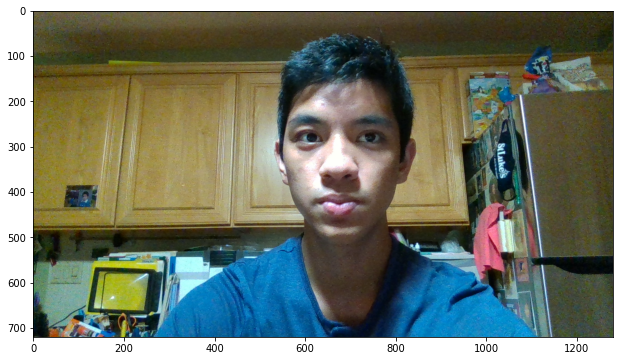

In [5]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

### Align Depth to RGB

In [6]:
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(rs.colorizer().colorize(aligned_depth_frame).get_data())

### RGBD Visualization (Aligned)

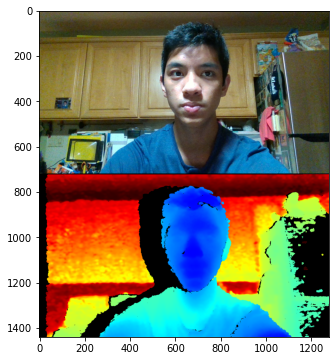

In [7]:
plt.imshow(np.vstack((color, colorized_depth)))

## Preliminary Data Analysis/Manipulation

In [8]:
distance_query_x = int(aligned_depth_frame.get_width() * 0.5)
distance_query_y = int(aligned_depth_frame.get_height() * 0.5)
print(f"Frame dimensions: {aligned_depth_frame.get_width():.0f} x {aligned_depth_frame.get_height():.0f} px")
queried_distance = aligned_depth_frame.get_distance(distance_query_x, distance_query_y)
print(f"Distance at ({distance_query_x}, {distance_query_y}): {queried_distance:.4f} m")

Frame dimensions: 1280 x 720 px
Distance at (640, 360): 0.4320 m


### Dlib Face, Facial Landmark Detection & Depth Querying

In [9]:
detector = dlib.get_frontal_face_detector() 
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") 

# Landmarks of interest
LANDMARKS_OF_INTEREST = (("NOSE_BRIDGE_TOP", 27), ("FACE_LEFT", 0), ("FACE_RIGHT", 16))
# Landmark dot color (RGB)
LANDMARK_REGULAR_COLOR = (0, 255, 255)
# Landmark of interest dot color (RGB)
LANDMARK_INTEREST_COLOR = (255, 100, 0)

Depth of FACE_LEFT is 0.4930 m
Depth of FACE_RIGHT is 0.4880 m
Depth of NOSE_BRIDGE_TOP is 0.4380 m
(Note: left/right directions are from perspective of camera)


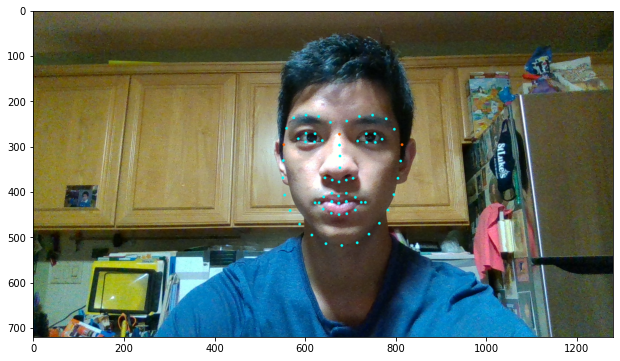

In [10]:
# RGB data
rgb_frame_data = np.asanyarray(frameset.get_color_frame().get_data())
# convert to grayscale for detection
gray = cv2.cvtColor(rgb_frame_data, cv2.COLOR_BGR2GRAY)

faces = detector(gray)
for face in faces:  
    x1 = face.left() 
    y1 = face.top() 
    x2 = face.right() 
    y2 = face.bottom() 
    landmarks = predictor(gray, face)

    landmark_interest_depths = []
    # Iterate through all landmarks
    for n in range(0, 68):
        x = landmarks.part(n).x 
        y = landmarks.part(n).y 
        is_landmark_of_interest = False
        landmark_name = None
        for (name, index) in LANDMARKS_OF_INTEREST:
            if(n == index):
                is_landmark_of_interest = True
                landmark_name = name
                break
        
        if(is_landmark_of_interest):
            cv2.circle(rgb_frame_data, (x, y), 3, LANDMARK_INTEREST_COLOR, -1)
            landmark_interest_depths.append((landmark_name, aligned_depth_frame.get_distance(x, y)))
        else:
            cv2.circle(rgb_frame_data, (x, y), 3, LANDMARK_REGULAR_COLOR, -1)
    for name, depth in landmark_interest_depths:
        print(f"Depth of {name} is {depth:.4f} m")
    print("(Note: left/right directions are from perspective of camera)")

    plt.imshow(rgb_frame_data)